# AR(1) processes and unit-root processes

We will simulate these categories of processes to understand how they behave and how to test for unit roots. Then we will apply the same tests to some example data.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import normal
import pandas as pd

import wrds
import fredapi

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.formula.api import ols

import os
from dotenv import load_dotenv
load_dotenv();

# Simulations

An AR1 process is given by:
$$
y_t = \mu + \phi y_{t-1} + u_t
$$
Below, we will simulate $1000$ observations of such a process, with $\mu = 0.01$ and $u_t \sim \mathcal{N}(0,1)$, and comparing various values of $\phi$.

We will start with $\phi = 0.8$.
Because $\phi < 1$ in this case, it doesn't really matter where we start the process: within a few observations, it settles down to a steady distribution, centered around the average value $\frac{\mu}{1-\phi}$ and with variance given by the formula in the slides. This is the meaning of "stationary." 

Statistical analysis, such as the unit-root tests that we will get to in a moment, assume that the data has already reached its stable distribution before you start collecting your sample. So in simulation exercises like the one below, it is common to throw away (or "burn off") some number of observations at the beginning, to make sure the process has a chance to reach that point. However, for simplicity we won't do that here.

Next, try $\phi=1$. As we simulate a few different times, we can see there is often a trend in the simulated data, but you can't guess in advance how steep it will be or even which way it will go. This is characteristic of a unit-root process. The trend we see is sometimes called a *stochastic trend*, because it is very likely that there will be *some* trend in any given simulation, but the exact shape of it is determined randomly by the specific outcome of that simulation.

In the scenario $\phi=1$, the code also plots the difference of the simulated series. The figure illustrates that this difference is a stationary process (with mean $\mu$ and standard deviation $\sigma$). This is an important fact that we will use often.

Finally, for the sake of completeness, try $\phi = 1.01$. Now the process is not stationary and simply grows "explosively" in almost every simulation (though not always in the same direction). The case of $\phi > 1$ is never seen in practice and we won't discuss it further.

In [2]:
# Choose our parameter values
sigma = 1
mu = 1
phi = 0.8
# phi = 1
# phi = 1.01

# Set the number of observations we want to simulate.
N = 1000

# Create an empty Series with N observations.
AR1 = pd.Series( np.full(N, np.nan) )

# Choose a random number to start the series: 
# Notice that when the process is stationary (phi<1), 
# then this initial value becomes irrelevant after a few dozen observations or so.
# On the other hand when the process is a random walk, the initial value is "remembered" forever.
AR1[0] = normal(0,10)

# Fill in the rest of the series after the first observation, using the AR1 formula
for i in range(1,N): AR1[i] = mu + phi*AR1[i-1]+ normal(0,sigma)

Plot the simulated data:

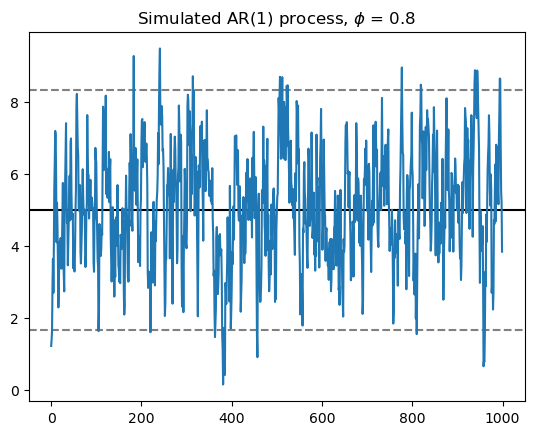

In [3]:
# To help visualize the long-run distribution of the series (when phi<1),
# we can plot the mean of this distribution, plus and minus two standard deviations,
# using the formulas from the slides.
# This should be roughly a 95% confidence interval for the long-run distribution,
# meaning that 95% of the observations should fall within this range after the series reaches its long-run state.
if phi < 1:
    AR1_mean = mu/(1-phi)
    AR1_var = sigma**2 / (1-phi**2)
    AR1_std = np.sqrt(AR1_var)
    plt.axhline(AR1_mean,color='black',linestyle='-');
    plt.axhline(AR1_mean + 2*AR1_std,color='gray',linestyle='--');
    plt.axhline(AR1_mean - 2*AR1_std,color='gray',linestyle='--');
    AR1.plot(title=r"Simulated AR(1) process, $\phi$ = "+str(phi));
    plt.show();

if phi == 1:
    AR1.plot(title="Simulated random walk process");
    plt.show()
    AR1.diff().plot(title="Difference of simulated random walk");
    plt.axhline(mu,color='black',linestyle='-')
    plt.axhline(mu+2*sigma,color='gray',linestyle='--')
    plt.axhline(mu-2*sigma,color='gray',linestyle='--')
    plt.show();

if phi > 1:
    AR1.plot(title="Simulated explosive process");
    plt.show();

In [6]:
ols("AR1 ~ AR1.shift()",data=AR1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AR1   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     1504.
Date:                Thu, 01 Jan 2026   Prob (F-statistic):          2.32e-201
Time:                        14:20:15   Log-Likelihood:                -1423.8
No. Observations:                 999   AIC:                             2852.
Df Residuals:                     997   BIC:                             2861.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1578      0.107     10.865      0.000       0.949       1.367
AR1.shift()     0.7735      0.020     38.787      0.000       0.734       0.813
==============================================================================
Omnibus:                        2.013   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.860
Skew:                           0.019   Prob(JB):                        0.395
Kurtosis:                       2.792   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Unit root tests with the simulated data:

**Dickey-Fuller test** for a unit root in a series: 

- Null hypothesis is that the process has a unit root.
- Alternative hypothesis is that it is stationary.

In the output below, the numbers are:

1. the test statistic,
2. the p-value from the test,
3. the number of lags included in the test, which is determined by our choice of the "maxlag" option; 
    - (with zero it's a classic DF test, with one or more lags it's an ADF test; see the slides and below),
4. the number of observations used in the test;
    - (this is always one less than the number of dates in the data, because the test involves $\Delta y$);
5. and then a list of critical values for the test at 1%, 5%, and 10% levels.

The main thing we care about is the p-value of the test.

- A low value means we **can reject** the null hypothesis that the series has a unit root.
- A high value means we **cannot reject** the null hypothesis that the series has a unit root.

In [7]:
adfuller(AR1)

(np.float64(-11.360106357779744),
 np.float64(9.519633581377662e-21),
 0,
 999,
 {'1%': np.float64(-3.4369127451400474),
  '5%': np.float64(-2.864437475834273),
  '10%': np.float64(-2.568312754566378)},
 np.float64(2793.103476712812))

Check that we know how to produce this test statistic: If we regress $\Delta y_t$ on $y_{t-1}$, then the $t$-statistic for the regression coefficient on $y_{t-1}$ is the DF test statistic. (But we won't look at the p-values from the regression, because they are based on the critical values of the usual $t$ distribution, and we know that the sampling distribution of the coefficient under the null hypothesis is a different, nonstandard distribution.)

In [8]:
ols("AR1.diff() ~ AR1.shift()",data=AR1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AR1.diff()   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     129.1
Date:                Thu, 01 Jan 2026   Prob (F-statistic):           3.29e-28
Time:                        14:20:15   Log-Likelihood:                -1423.8
No. Observations:                 999   AIC:                             2852.
Df Residuals:                     997   BIC:                             2861.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1578      0.107     10.865      0.000       0.949       1.367
AR1.shift()    -0.2265      0.020    -11.360      0.000      -0.266      -0.187
==============================================================================
Omnibus:                        2.013   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.860
Skew:                           0.019   Prob(JB):                        0.395
Kurtosis:                       2.792   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
ols("AR1.diff() ~ AR1.shift()",data=AR1).fit().tvalues['AR1.shift()']

np.float64(-11.360106357779745)

**Augmented Dickey-Fuller test** (ADF). Everything is the same, but we control for lags of $\Delta y_t$ to allow for a more general dynamic structure. 

(This is the usual approach in practice, not the "classic" DF test that we ran just above.)

First we try just adding just one lag of $\Delta y_t$. We do this by adding "maxlag=1" as an option. We also need set "autolag=None." 

- If I don't do this, and maxlag is a positive number, then the code will assume I want to search over *all* possible choices of lag up to "maxlag", and choose the ideal number of lags according to an information criterion. In the next example we will do this, but for now I don't want to.
- Notice also that the number of observations falls by one more in the output, because now for each month $t$ we need to control for $\Delta y_{t-1}$.

In [10]:
print("ADF test results with one lag (phi = " + str(phi) + ")")
display(adfuller(AR1,maxlag=1,autolag=None))

ADF test results with one lag (phi = 0.8)


(np.float64(-11.072300121699524),
 np.float64(4.5216212675477793e-20),
 1,
 998,
 {'1%': np.float64(-3.4369193380671),
  '5%': np.float64(-2.864440383452517),
  '10%': np.float64(-2.56831430323573)})

Again, match the test statistic with a regression:

In [11]:
ols("AR1.diff() ~ AR1.shift() + AR1.diff().shift()",data=AR1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AR1.diff()   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     65.25
Date:                Thu, 01 Jan 2026   Prob (F-statistic):           2.36e-27
Time:                        14:20:15   Log-Likelihood:                -1422.1
No. Observations:                 998   AIC:                             2850.
Df Residuals:                     995   BIC:                             2865.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.2002      0.113     10.645      0.000       0.979       1.421
AR1.shift()           -0.2347      0.021    -11.072      0.000      -0.276      -0.193
AR1.diff().shift()     0.0320      0.032      1.011      0.312      -0.030       0.094
==============================================================================
Omnibus:                        2.048   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.891
Skew:                           0.022   Prob(JB):                        0.389
Kurtosis:                       2.791   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It's not necessarily clear how many lags we should choose in the ADF test. 

A common approach is to let the computer select this automatically according to an information criterion. Let's try this out. All we have to do is not specify the "maxlag" option, and not set "autolag=False" (by default it is true). 

By default the code uses the Akaike information criterion (AIC) to select the optimal number of lags. The other common choice is the Bayesian information criterion (BIC). They should yield basically the same conclusion.

In [12]:
adfuller(AR1)

(np.float64(-11.360106357779744),
 np.float64(9.519633581377662e-21),
 0,
 999,
 {'1%': np.float64(-3.4369127451400474),
  '5%': np.float64(-2.864437475834273),
  '10%': np.float64(-2.568312754566378)},
 np.float64(2793.103476712812))

**KPSS tests**: The ADF test tells us whether there is evidence to change our mind, if we already believe the series has a unit root. What about in the other direction? The KPSS tests asks, if we think the data are stationary, is there clear evidence to change our mind from *that*? We hope that KPSS rejects whenever ADF fails to reject, and vice versa, but life is not always that easy.

Note: In statsmodels, there are not many critical values stored for the KPSS test. In particular, it does not store any critical values corresponding to $p < 0.01$ or $p > 0.1$. The idea is that critical values outside this range are not necessary, because you will definitely reject for any $p < 0.01$ and definitely refuse to reject for any $p > 0.1$. So if it encounters a test statistic outside this range, it will report $p=0.01$ or $p=0.1$, along with an error message telling us that the true value is beyond this limit.

In [13]:
kpss(AR1)

/tmp/ipykernel_1144407/1454636084.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(AR1)


(np.float64(0.2288674140443379),
 np.float64(0.1),
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

As you experiment with different values of $\phi$ in the code above, you will see that the tests perform fairly well on simulated data, except for values of $\phi$ that are close to 1 but just slightly less. This is not too surprising, as these are exactly the situations where it should be very difficult to tell the difference between a stationary and nonstationary process.

# Data

We will use three different data series to illustrate unit root tests:

### Unemployment (seasonally adjusted, monthly frequency)

Suppose we want to perform some statistical analysis involving the unemployment rate.
We should first check that this series is stationary.

Download and plot a few decades of this data series:

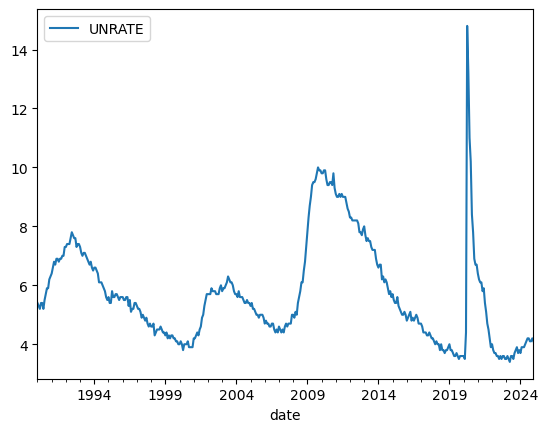

In [14]:
UNRATE = fredapi.Fred().get_series('UNRATE', observation_start = '1990-01-01', observation_end = '2024-12-31', frequency='m', aggregation_method = 'eop').to_frame().reset_index().rename(columns={"index":"date" , 0:"UNRATE"}).set_index('date')
UNRATE.plot();

Unit root tests suggest that the series is indeed stationary. This is not too surprising, because the rate must stay between zero and 100%, and has never stayed permanently at any high level in US history.

In [15]:
print("ADF test results for UNRATE:")
display(adfuller(UNRATE))
print("KPSS test results for UNRATE:")
display(kpss(UNRATE))

ADF test results for UNRATE:


(np.float64(-3.004056817844361),
 np.float64(0.03451727745171413),
 2,
 417,
 {'1%': np.float64(-3.446129402876608),
  '5%': np.float64(-2.8684960761128346),
  '10%': np.float64(-2.570475362616382)},
 np.float64(682.1829026271241))

KPSS test results for UNRATE:


/tmp/ipykernel_1144407/2113439240.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  display(kpss(UNRATE))


(np.float64(0.26213451922855757),
 np.float64(0.1),
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Once we know the process is stationary, we can proceed to standard statistical analysis. 

For example, suppose we want to check whether this data is well described by an AR(1) model. We can just estimate $\phi$ with a regression as discussed in class. The results suggest that the series is extremely persistent, with $\phi \approx 0.95$, but this is still not quite the same as having a unit root. 

Remember that $\frac{\mu}{1-\phi}$ tells us the "average" long-run value of the AR1 process. In this case it works out to about $\frac{0.2850}{1-0.9496} = 5.65\%$. By comparison, the sample mean of UNRATE in the data is 5.71\%. In any AR1 estimation, these numbers will be close to each other.

In [16]:
print( ols("UNRATE ~ UNRATE.shift()",data=UNRATE).fit().summary() )

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     3754.
Date:                Thu, 01 Jan 2026   Prob (F-statistic):          1.25e-210
Time:                        14:20:16   Log-Likelihood:                -346.20
No. Observations:                 419   AIC:                             696.4
Df Residuals:                     417   BIC:                             704.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2850      0.093      3.

## 10-year Treasury rate

This series fails to be stationary simply because it has trended downward for decades. 

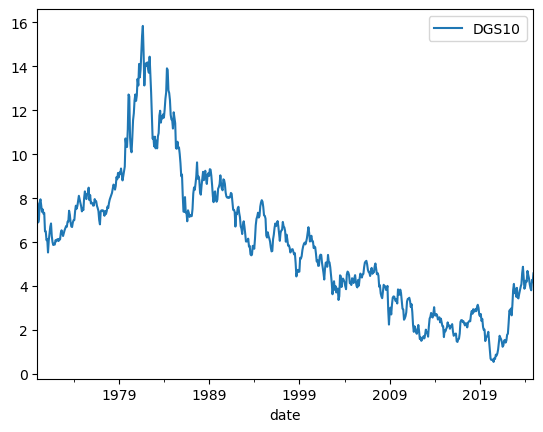

In [17]:
DGS10 = fredapi.Fred().get_series('DGS10', observation_start = '1970-01-01', observation_end = '2024-12-31', frequency='m', aggregation_method = 'eop').to_frame().reset_index().rename(columns={"index":"date" , 0:"DGS10"}).set_index('date')
DGS10 = DGS10.dropna()
DGS10.plot();

Not surprisingly, the tests tell us that the process is not stationary:

In [18]:
display(adfuller(DGS10))
display(kpss(DGS10))

(np.float64(-1.4215858642593169),
 np.float64(0.5718849580413695),
 2,
 657,
 {'1%': np.float64(-3.440342440623255),
  '5%': np.float64(-2.8659491890487026),
  '10%': np.float64(-2.569118060113657)},
 np.float64(408.78953971356214))

/tmp/ipykernel_1144407/1360959267.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  display(kpss(DGS10))


(np.float64(2.9196274827805926),
 np.float64(0.01),
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

This is a good example of a "stochastic" trend: Prices follow a random walk, so it is not surprising that we see a strong trend when we look back over a historical window. Yet, no one could have predicted in advance whether this trend would have been upward or downward, and as of right now, we don't know what the future trend will be either.

### GDP (seasonally adjusted, annual rate, quarterly frequency)

This is the same data series that we saw last week:

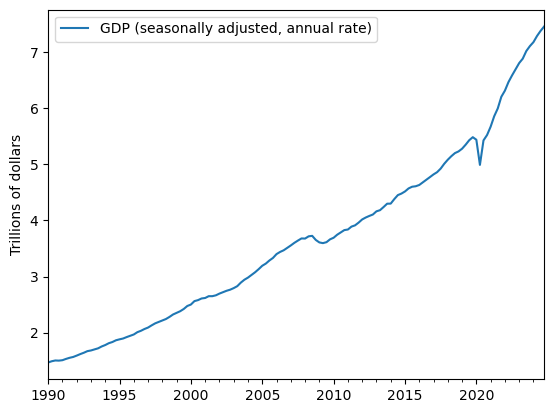

In [19]:
GDP = fredapi.Fred().get_series('GDP', observation_start = '1990-01-01', observation_end = '2024-12-31', frequency='q', aggregation_method = 'eop')
GDP = GDP / 1000
GDP = GDP / 4
GDP.plot(legend=True,label="GDP (seasonally adjusted, annual rate)",ylabel="Trillions of dollars");

<Axes: >

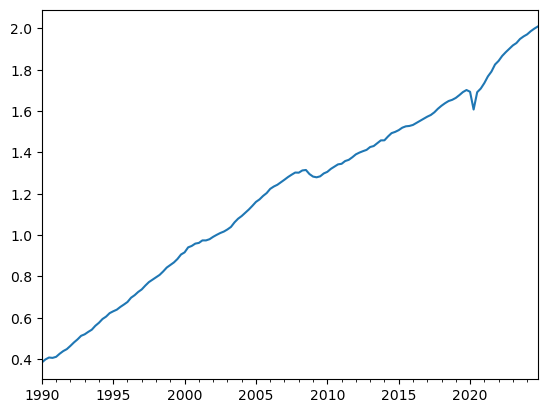

In [20]:
np.log(GDP).plot()

GDP trends upward steadily over time, so it should be obvious that unit-root tests will tell us it is not stationary:

In [21]:
print("ADF test results for GDP:")
display(adfuller(GDP))
print("KPSS test results for GDP:")
display(kpss(GDP))

ADF test results for GDP:


(np.float64(4.0773122824226),
 1.0,
 0,
 139,
 {'1%': np.float64(-3.4782936965183815),
  '5%': np.float64(-2.882567574015525),
  '10%': np.float64(-2.5779830117488745)},
 np.float64(-324.1065596407142))

KPSS test results for GDP:


/tmp/ipykernel_1144407/606141015.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  display(kpss(GDP))


(np.float64(2.0149739718931725),
 np.float64(0.01),
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

How to deal with this? We need to difference in some way. The usual approach is to take the log of GDP, then difference, so that we can interpret the difference as a growth rate similar to a percentage.

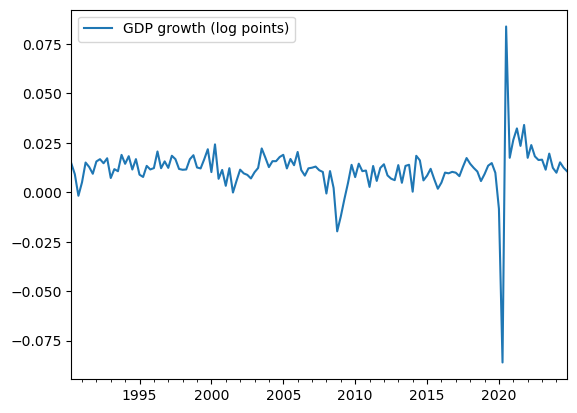

In [22]:
GDP_growth = np.log(GDP).diff().dropna()
GDP_growth.plot(legend=True,label="GDP growth (log points)");

The figure above provides much more hope that this series will be stationary, and the unit root tests confirm this:

In [23]:
display(adfuller(GDP_growth))
display(kpss(GDP_growth))

(np.float64(-12.422443462051103),
 np.float64(4.108322016652627e-23),
 0,
 138,
 {'1%': np.float64(-3.47864788917503),
  '5%': np.float64(-2.882721765644168),
  '10%': np.float64(-2.578065326612056)},
 np.float64(-721.1633569416203))

/tmp/ipykernel_1144407/3660239749.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  display(kpss(GDP_growth))


(np.float64(0.13990450983371372),
 np.float64(0.1),
 2,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Again, once we have a stationary series, it is valid to do statistical analysis, such as fitting an AR1 model. We will pick up with this example next week.